# Prepare Environment

In [1]:
# Install required libraries
!pip install -U kaleido # for saving graphs

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [4]:
!pip install --upgrade plotly>=6.1.1

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import joblib
import plotly.io as pio
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError
import os
import pickle
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K

# Useful Functions

In [6]:
# @title Filling missing values

def fill_missing_dates(df, date_column='date'):
    df[date_column] = pd.to_datetime(df[date_column])
    df = df.set_index(date_column).sort_index()

    # Reindex to continuous daily frequency
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(full_range)

    # interpolate missing values
    df.interpolate(method='linear', inplace=True)

    # Rename the index for clarity (optional)
    df.index.name = date_column

    return df


In [7]:
# @title Defining create_sequences (for single feature) function
def create_sequences(data, window_size=30, horizon=30): # window_size=30: Use last 30 days of data as input/horizon=30: Predict the price 30 day into the future
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1])
    return np.array(X), np.array(y)

In [8]:
# @title Defining create_sequences_multifeature function and inverse

def create_sequences_multifeature(data, window_size=30, horizon=30):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+horizon-1][0])  # <== ONLY take the first feature (TTF_Price)
    return np.array(X), np.array(y)


def inverse_single_feature(scaler, y_scaled, feature_index=0, total_features=3):
    """
    Inverse transform a single target feature from a scaler trained on multiple features.

    Parameters:
    - scaler: the fitted MinMaxScaler or StandardScaler
    - y_scaled: 1D array of scaled target values
    - feature_index: index of the feature to place into the dummy matrix (default: 0)
    - total_features: number of features originally fit in scaler

    Returns:
    - 1D array of inverse-transformed values
    """
    y_scaled = np.asarray(y_scaled).flatten()  # ✅ works with both NumPy and TensorFlow
    dummy = np.zeros((len(y_scaled), total_features))
    dummy[:, feature_index] = y_scaled
    return scaler.inverse_transform(dummy)[:, feature_index]

In [9]:
# Path to saved results
results_path = '/content/drive/MyDrive/BKW/reports/JKM/test_results_JKM_LSTM_model.csv'

if os.path.exists(results_path):
    results_df = pd.read_csv(results_path)
    if 'features' not in results_df.columns:
        results_df['features'] = np.nan  # add column if missing
else:
    results_df = pd.DataFrame(columns=['Label', 'MAE', 'MSE', 'RMSE', 'R2', 'cutoff_date', 'features'])

In [10]:
def evaluation_metrics(y_true, y_pred, label='', cutoff_date=None, features=None, results_df=None, save_path=None):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"{label:<30} | MAE: {mae:>6.3f}  MSE: {mse:>6.3f}  RMSE: {rmse:>6.3f}  R²: {r2:>6.3f}")

    # Check for existing entry to avoid duplicates
    if results_df is not None:
        exists = ((results_df['Label'] == label) & (results_df['cutoff_date'] == str(cutoff_date))).any()
        if not exists:
            features_str = ', '.join(features) if isinstance(features, list) else str(features)
            results_df.loc[len(results_df)] = [label, mae, mse, rmse, r2, cutoff_date, features_str]
            if save_path:
                results_df.to_csv(save_path, index=False)

    return results_df

In [11]:
# @title Defining a plotting function for the traning history
def plot_loss(history):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
# @title Defining a plotting function to plot the historical data, actual and predicted price on the forecasting date
def plot_lstm_forecast_aligned_to_forecast_date(
    df_all,
    forecast_dates,
    y_pred_inv,
    y_true_inv,
    horizon_days,
    title='Price Forecast (Aligned to Forecast Date)',
    save_path=None,   # e.g., '/content/drive/My Drive/BKW/reports'
    save_format='png' # 'png', 'pdf', 'svg', etc. (requires kaleido)
):
    """
    Plots historical  prices, and shows predicted & actual target prices on the forecast date.

    Parameters:
    - df_all: DataFrame with 'TTF_Price' and datetime index (historical)
    - forecast_dates: dates when forecasts were made
    - y_pred_inv: predicted prices for target dates (already inverse-transformed)
    - y_true_inv: actual target prices (already inverse-transformed)
    - horizon_days: how far ahead the forecast is (e.g., 30 for 1-month)
    - title: chart title
    - save_path: full file path to save the plot (optional)
    - save_format: file format (default 'png')

    Returns:
    - fig: the plotly figure object
    """

    # Convert inputs to pandas Series for indexing
    forecast_dates = pd.to_datetime(forecast_dates)
    y_pred_series = pd.Series(y_pred_inv.flatten(), index=forecast_dates)

    # Shift actual target values back to the forecast date
    actual_target_dates = forecast_dates + pd.Timedelta(days=horizon_days)
    y_true_series = pd.Series(y_true_inv.flatten(), index=actual_target_dates)
    y_true_aligned = y_true_series.shift(-horizon_days, freq='D')  # move back to forecast date

    # Start building the plot
    fig = go.Figure()

    # Historical TTF price
    fig.add_trace(go.Scatter(
        x=df_all.index,
        y=df_all['JKM_Price'],
        mode='lines',
        name='Historical Price',
        line=dict(color='lightgray'),
        opacity=0.5
    ))

    # Predicted target prices (plotted on forecast date)
    fig.add_trace(go.Scatter(
        x=y_pred_series.index,
        y=y_pred_series.values,
        mode='lines+markers',
        name=f'Predicted price (+{horizon_days}D)',
        marker=dict(size=2.5),
        line=dict(color='orange')
    ))

    # Actual future prices aligned to forecast date
    fig.add_trace(go.Scatter(
        x=y_true_aligned.index,
        y=y_true_aligned.values,
        mode='lines+markers',
        name=f'Actual price (+{horizon_days}D)',
        marker=dict(size=2.5),
        line=dict(color='blue')
    ))

    # Layout
    fig.update_layout(
        title=title,
        xaxis_title='Forecast Date',
        yaxis_title='JKM_Price ($/MMBtu)',
        hovermode='x unified',
        xaxis=dict(tickangle=-45),
        height=600
    )

    fig.show()

    # Optionally save the plot
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.write_image(save_path, format=save_format)
        print(f"✅ Plot saved to: {save_path}")

    return fig

In [13]:
#@title Function to Save Model and Training History
import os
import pickle

def save_model_and_history(model, history, save_dir, model_name='lstm_model'):
    """
    Saves a Keras model and its training history to the specified directory.

    Parameters:
    - model: trained Keras model
    - history: result of model.fit()
    - save_dir: directory path (e.g., '/content/drive/My Drive/LNG_Forecasts/')
    - model_name: base name for saved files (default: 'lstm_model')
    """
    os.makedirs(save_dir, exist_ok=True)

    # Save model
    model_path = os.path.join(save_dir, f'{model_name}.keras')
    model.save(model_path)

    # Save history
    history_path = os.path.join(save_dir, f'{model_name}_history.pkl')
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

    print(f"✅ Model saved to: {model_path}")
    print(f"✅ History saved to: {history_path}")

In [14]:
#@title Function to Load Model and Training History
import os
import pickle
from tensorflow.keras.models import load_model

def load_model_and_history(save_dir, model_name='lstm_model'):
    """
    Loads a saved Keras model and optionally its training history.

    Parameters:
    - save_dir: Directory path
    - model_name: Base name used when saving

    Returns:
    - model: Loaded Keras model
    - history: Training history (as a dict), or None if not found
    """
    # Load model
    model_path = os.path.join(save_dir, f'{model_name}.keras')
    model = load_model(model_path)
    print(f"✅ Model loaded from: {model_path}")

    # Attempt to load history
    history_path = os.path.join(save_dir, f'{model_name}_history.pkl')
    history = None
    if os.path.exists(history_path):
        try:
            with open(history_path, 'rb') as f:
                history = pickle.load(f)
            print(f"✅ History loaded from: {history_path}")
        except Exception as e:
            print(f"⚠️ Error loading history: {e}")
    else:
        print(f"⚠️ History file not found at: {history_path}")

    return model, history

In [15]:
# @title Defining a function to save the forecast results
def save_lstm_forecast_results_full(
    forecast_dates,
    features_df,
    y_pred_inv,
    y_true_inv,
    horizon_days,
    save_path=None
):
    """
    Adds predicted and actual prices to a full-length feature DataFrame, aligned by forecast date.

    Parameters:
    - forecast_dates: list of forecast dates (len = N)
    - features_df: full-length DataFrame with datetime index (len = M)
    - y_pred_inv: predicted values (N,)
    - y_true_inv: actual values (N,)
    - horizon_days: forecast horizon (used in column naming)
    - save_path: optional file path to save

    Returns:
    - DataFrame with added columns for predictions and true values
    """
    forecast_dates = pd.to_datetime(forecast_dates)

    # Create aligned series
    y_pred_series = pd.Series(y_pred_inv.flatten(), index=forecast_dates)
    actual_target_dates = forecast_dates + pd.Timedelta(days=horizon_days)
    y_true_series = pd.Series(y_true_inv.flatten(), index=actual_target_dates)
    y_true_aligned = y_true_series.shift(-horizon_days, freq='D')

    # Copy and assign predictions into matching rows
    df_result = features_df.copy()

    df_result[f'Predicted_{horizon_days}D'] = pd.NA
    df_result[f'Actual_{horizon_days}D'] = pd.NA

    # Assign only where we have predictions
    df_result.loc[y_pred_series.index, f'Predicted_{horizon_days}D'] = y_pred_series
    df_result.loc[y_true_aligned.index, f'Actual_{horizon_days}D'] = y_true_aligned

    # Save if path is given
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        df_result.to_csv(save_path)
        print(f"✅ Forecast results saved to: {save_path}")

    return df_result

# Loading data and EDA

In [16]:
#@title load data
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/BKW/LNG Project data/' # if running this notebook in colab
# data_path = '../../data/LNG Project data/' # if running this notebook locally

file_path = 'DATA from 2009 (on progress)/Price_inv_stor_LNG_water_pipe_TTFMc_raw_FIXED.xlsx'

# Load and prepare data
df_all = pd.read_excel(data_path + file_path)
df_all.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,PSV_Price,Brent_Price,TTF_Futures_Price,PVB_Price,JKM_Price,NBP_Price,CBOE_Price,Coal_Price,HH_Price,...,TTFMc4_Ask,TTFMc5_Close,TTFMc6_Close,TTFMc6_OI,TTFMc7_Close,TTFMc7_OI,TTFMc8_Close,TTFMc8_OI,TTFMc9_Close,TTFMc9_OI
0,2009-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-02,NaN,46.91,NaN,NaN,NaN,NaN,39.19,74.35,5.41,...,17.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-05,NaN,49.62,NaN,NaN,NaN,NaN,39.08,77.65,5.83,...,17.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#@title plot certain columns
# cols_to_plot = ['HenryHub_Price']

cols_to_plot = ['Brent_Price', 'CBOE_Price', 'Coal_Price', 'HH_Price','JKM_Price', 'NBP_Price', 'PSV_Price', 'TTF_Price']

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_all[cols_to_plot]), columns=cols_to_plot)
df_scaled['Date'] = df_all['Date']

fig = go.Figure()
for col in cols_to_plot:
    fig.add_trace(go.Scatter(x=df_scaled['Date'], y=df_scaled[col], mode='lines', name=col))

fig.update_layout(
    title='Normalized Energy Price Trends (Scaled)',
    xaxis_title='Date',
    yaxis_title='Scaled Value',
    xaxis=dict(tickformat='%Y-%m', tickangle=-45, dtick="M3", tickfont=dict(size=8)),
    yaxis=dict(tickfont=dict(size=10)),
    hovermode='x unified',
    height=600
)
fig.show()

# Ensure the directory exists before saving the HTML file
html_save_dir = '/content/drive/My Drive/BKW/reports'
os.makedirs(html_save_dir, exist_ok=True)
fig.write_html(os.path.join(html_save_dir, "Normalized Energy Price Trend -Key LNG Indices & Oil coal price.html"))

In [ ]:
#@title plot certain columns
# cols_to_plot = ['HenryHub_Price']

cols_to_plot = ['Brent_Price', 'CBOE_Price', 'Coal_Price', 'HH_Price','JKM_Price', 'NBP_Price', 'PSV_Price', 'TTF_Price']


fig = go.Figure()
for col in cols_to_plot:
    fig.add_trace(go.Scatter(x=df_selected_features.index, y=df_selected_features[col], mode='lines', name=col))

fig.update_layout(
    title='JKM',
    xaxis_title='Date',
    yaxis_title='Value',
    xaxis=dict(tickformat='%Y-%m', tickangle=-45, dtick="M3", tickfont=dict(size=8)),
    yaxis=dict(tickfont=dict(size=10)),
    hovermode='x unified',
    height=600
)
fig.show()

"""# Ensure the directory exists before saving the HTML file
html_save_dir = '/content/drive/My Drive/BKW/reports'
os.makedirs(html_save_dir, exist_ok=True)
fig.write_html(os.path.join(html_save_dir, "Normalized Energy Price Trend -Key LNG Indices & Oil coal price.html"))"""

'# Ensure the directory exists before saving the HTML file\nhtml_save_dir = \'/content/drive/My Drive/BKW/reports\'\nos.makedirs(html_save_dir, exist_ok=True)\nfig.write_html(os.path.join(html_save_dir, "Normalized Energy Price Trend -Key LNG Indices & Oil coal price.html"))'

In [17]:
df_selected_features = df_all[["Date",
                               "JKM_Price",
                               "PSV_Price",
                               "TTF_Price",
 'TTFMc1_Close',
 'TTFMc2_Close',
 'TTFMc3_Close',
 'NetImports_Total',
 'Temp_Southern_Hemisphere',
 'Temp_Global',
 'Temp_Northern_Hemisphere',
 'Brent_Price',
 'Brent_Volume',
 'Coal_Price',
 'TTFMc1_Bid',
 'TTFMc1_Ask',
 'CBOE_Price',
 'TTFMc2_Bid',
 'HH_Price',
 'TTFMc2_Ask',
 'NBP_Price']].copy()
df_selected_features.head(1)

,Date,JKM_Price,PSV_Price,TTF_Price,TTFMc1_Close,TTFMc2_Close,TTFMc3_Close,NetImports_Total,Temp_Southern_Hemisphere,Temp_Global,...,Brent_Price,Brent_Volume,Coal_Price,TTFMc1_Bid,TTFMc1_Ask,CBOE_Price,TTFMc2_Bid,HH_Price,TTFMc2_Ask,NBP_Price
0,2009-01-01,NaN,NaN,21.0,21.45,21.0,21.8,694352.0,15.963,12.58,...,NaN,NaN,NaN,21.3,21.5,NaN,21.0,NaN,21.3,NaN


In [18]:
df_all.isna().sum()

,0
Date,0
PSV_Price,2595
Brent_Price,1772
TTF_Futures_Price,4097
PVB_Price,4773
...,...
TTFMc7_OI,5361
TTFMc8_Close,5370
TTFMc8_OI,5371
TTFMc9_Close,5411


In [19]:
df_selected_features = fill_missing_dates(df_selected_features, date_column='Date')
df_selected_features.isna().sum()

,0
JKM_Price,1365
PSV_Price,917
TTF_Price,0
TTFMc1_Close,0
TTFMc2_Close,0
TTFMc3_Close,0
NetImports_Total,0
Temp_Southern_Hemisphere,0
Temp_Global,0
Temp_Northern_Hemisphere,0


In [20]:
"""df_selected_features["floating_storages_Asia"]  = df_all["floating_storages_Asia"]
df_selected_features["NetImports_Total"]  = df_all["NetImports_Total"]
df_selected_features["floating_storages_Europe"]  = df_all["floating_storages_Europe"]"""

'df_selected_features["floating_storages_Asia"]  = df_all["floating_storages_Asia"]\ndf_selected_features["NetImports_Total"]  = df_all["NetImports_Total"]\ndf_selected_features["floating_storages_Europe"]  = df_all["floating_storages_Europe"]'

In [21]:
target = "JKM_Price"

#@title adding some technical features
#df_selected_features['month'] = df_selected_features.index.month  # Integer (1–12)
#df_selected_features['sin_day'] = np.sin(2 * np.pi * df_selected_features.index.dayofyear / 365.25)
#df_selected_features['cos_day'] = np.cos(2 * np.pi * df_selected_features.index.dayofyear / 365.25)
df_selected_features['JKM_Price_pct_change'] = df_selected_features[target].pct_change()
df_selected_features['MA_7'] = df_selected_features[target].rolling(7).mean()
df_selected_features['Volatility_30'] = df_selected_features[target].rolling(30).std()
df_selected_features['return_30'] = df_selected_features[target].pct_change(30)
df_selected_features['return_60'] = df_selected_features[target].pct_change(60)
df_selected_features['rolling_std_30'] = df_selected_features[target].pct_change().rolling(30).std()
df_selected_features['z_score_30'] = (df_selected_features[target] - df_selected_features[target].rolling(30).mean()) / df_selected_features[target].rolling(30).std()
df_selected_features['bollinger_width'] = 4 * df_selected_features[target].rolling(30).std() / df_selected_features[target].rolling(30).mean()

In [ ]:
df_selected_features.shape

(6037, 28)

In [22]:
df_selected_features = df_selected_features[['JKM_Price', 'PSV_Price', 'TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close',
       'TTFMc3_Close', 'Temp_Southern_Hemisphere',
       'Temp_Global', 'Temp_Northern_Hemisphere', 'Brent_Price',
       'Brent_Volume', 'Coal_Price', 'TTFMc1_Bid', 'TTFMc1_Ask', 'CBOE_Price',
       'TTFMc2_Bid', 'HH_Price',  'NBP_Price',
       'JKM_Price_pct_change', 'MA_7', 'Volatility_30', 'return_30',
       'return_60', 'rolling_std_30', 'z_score_30', 'bollinger_width']]
df_selected_features.isna().sum()
#df_selected_features.dropna(inplace=True)

,0
JKM_Price,1365
PSV_Price,917
TTF_Price,0
TTFMc1_Close,0
TTFMc2_Close,0
TTFMc3_Close,0
Temp_Southern_Hemisphere,0
Temp_Global,0
Temp_Northern_Hemisphere,0
Brent_Price,1


In [23]:
df_selected_features.dropna(inplace=True)

/tmp/ipython-input-23-2910231137.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_features.dropna(inplace=True)


In [24]:
#@title plot certain columns
# cols_to_plot = ['HenryHub_Price']

cols_to_plot = ['JKM_Price']


fig = go.Figure()
for col in cols_to_plot:
    fig.add_trace(go.Scatter(x=df_selected_features.index, y=df_selected_features[col], mode='lines', name=col))

fig.update_layout(
    title='JKM',
    xaxis_title='Date',
    yaxis_title='Value',
    xaxis=dict(tickformat='%Y-%m', tickangle=-45, dtick="M3", tickfont=dict(size=8)),
    yaxis=dict(tickfont=dict(size=10)),
    hovermode='x unified',
    height=600
)
fig.show()

# Models

In [ ]:
featu_col = []
for col in df_selected_features.columns:
  featu_col.append(col)
  print(featu_col)

['JKM_Price']
['JKM_Price', 'PSV_Price']
['JKM_Price', 'PSV_Price', 'TTF_Price']
['JKM_Price', 'PSV_Price', 'TTF_Price', 'TTFMc1_Close']
['JKM_Price', 'PSV_Price', 'TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close']
['JKM_Price', 'PSV_Price', 'TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close', 'TTFMc3_Close']
['JKM_Price', 'PSV_Price', 'TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close', 'TTFMc3_Close', 'Temp_Southern_Hemisphere']
['JKM_Price', 'PSV_Price', 'TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close', 'TTFMc3_Close', 'Temp_Southern_Hemisphere', 'Temp_Global']
['JKM_Price', 'PSV_Price', 'TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close', 'TTFMc3_Close', 'Temp_Southern_Hemisphere', 'Temp_Global', 'Temp_Northern_Hemisphere']
['JKM_Price', 'PSV_Price', 'TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close', 'TTFMc3_Close', 'Temp_Southern_Hemisphere', 'Temp_Global', 'Temp_Northern_Hemisphere', 'Brent_Price']
['JKM_Price', 'PSV_Price', 'TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close', 'TTFMc3_Close', 'Temp_Southern_Hemisphere', 'Temp_G

In [ ]:
#@title model_multi_dani8_5_2023 with 7 features
from datetime import datetime
# Step 1: Scale the features
scaler = MinMaxScaler()

featu_col = []
for col in df_selected_features.columns:
  featu_col.append(col)

  feature_columns = featu_col
  num_features = len(feature_columns)# Get current timestamp in a readable format
  timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
  features = df_selected_features[feature_columns]
  scaled = scaler.fit_transform(features)


  # Define parameters
  window_size = 180
  horizon_days = 30
  cutoff_date = '2021-12-31'
  split_idx = df_selected_features.index.get_loc(cutoff_date)
  buffer = window_size + horizon_days - 1

  # split the data
  scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
  scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

  # Now safely create sequences
  X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
  X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


    # Build and Train the LSTM Model
  # Build model
  model_multi_dani = Sequential([
      Input(shape=(X_train.shape[1], X_train.shape[2])),
      LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
      Dropout(0.4),
      LSTM(32),                            # Second LSTM layer outputs a vector
      Dropout(0.2),
      Dense(1)                             # Predict a single target value
  ])

  model_multi_dani.compile(
      optimizer=Adam(),
      loss='mse',
    metrics=[
          MeanAbsoluteError(name='mae'),
          RootMeanSquaredError(name='rmse'),
          MeanAbsolutePercentageError(name='mape')
      ]
    )
  # Early stopping
  early_stop = EarlyStopping(
      monitor='val_loss',
      patience=5,
      restore_best_weights=True
  )

  lr_scheduler = ReduceLROnPlateau(
      monitor='val_loss',     # Watch this metric
      factor=0.5,             # Reduce LR by half
      patience=3,             # Wait for 3 epochs with no improvement
      verbose=1               # Print updates
  )


  # Manual chronological split from training set (e.g., last 10% of X_train)
  val_size = int(len(X_train) * 0.1)
  X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
  y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


  # Train model
  history_multi_dani_15 = model_multi_dani.fit(X_train_sub, y_train_sub,
                      epochs=50,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=[early_stop, lr_scheduler],
      verbose=1)
#@title Evaluate the model_multi_dani_15 result by inverse y_test and y_pred during  war and post war periods

  # After model prediction (in scaled space)
  y_pred_scaled = model_multi_dani.predict(X_test)

  # Inverse just the price component
  y_pred_multi_dani = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=len(features.columns))
  y_test_multi_dani = inverse_single_feature(scaler, y_test, feature_index=0, total_features=len(features.columns))

  evaluation_metrics(y_test_multi_dani, y_pred_multi_dani, label =f"model_multi_dani_{num_features}_War_{timestamp}", cutoff_date = '2021-12-31', results_df = results_df, features = feature_columns)

    # --- Step 3: Construct datetime index for y_test/y_pred ---
  test_start_idx = split_idx + 1 - buffer
  forecast_start_idx = test_start_idx + window_size + horizon_days - 1
  forecast_dates = df_selected_features.index[forecast_start_idx : forecast_start_idx + len(y_test_multi_dani)]

  y_pred_series = pd.Series(y_pred_multi_dani, index=forecast_dates)
  y_test_series = pd.Series(y_test_multi_dani, index=forecast_dates)

  # --- Step 4: Define period masks ---
  war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
  postwar_mask = forecast_dates > '2023-03-31'

  # --- Step 5: Evaluate both periods ---
  results_df = evaluation_metrics(
      y_test_series[war_mask], y_pred_series[war_mask],
      label=f"model_multi_dani_{num_features}_War_{timestamp}", cutoff_date = cutoff_date, results_df=results_df, features = feature_columns)

  results_df = evaluation_metrics(
      y_test_series[postwar_mask], y_pred_series[postwar_mask],
      label=f"model_multi_dani_{num_features}_War_{timestamp}", cutoff_date = cutoff_date, results_df=results_df, features =feature_columns)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - loss: 0.0019 - mae: 0.0310 - mape: 591.6226 - rmse: 0.0419 - val_loss: 0.0092 - val_mae: 0.0718 - val_mape: 30.3861 - val_rmse: 0.0961 - learning_rate: 0.0010
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 179ms/step - loss: 6.6789e-04 - mae: 0.0177 - mape: 2795.3916 - rmse: 0.0258 - val_loss: 0.0111 - val_mae: 0.0804 - val_mape: 32.3631 - val_rmse: 0.1055 - learning_rate: 0.0010
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - loss: 6.5109e-04 - mae: 0.0176 - mape: 2858.8152 - rmse: 0.0255 - val_loss: 0.0094 - val_mae: 0.0718 - val_mape: 29.2574 - val_rmse: 0.0969 - learning_rate: 0.0010
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 5.7448e-04 - mae: 0.0166 - mape: 789.0255 - rmse: 0.0240
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - loss: 5.7437e-04 - mae: 0.0166 - mape: 870.8499 - rmse: 0.0240 - val_loss: 0.0109 - val_mae: 0.0793 - val_mape:

# Rebuild the best model from the above excercise

From the above features search, it seems the best model for 30 days horizon is to use the following 23 features:

['JKM_Price', 'PSV_Price', 'TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close', 'TTFMc3_Close', 'Temp_Southern_Hemisphere', 'Temp_Global', 'Temp_Northern_Hemisphere', 'Brent_Price', 'Brent_Volume', 'Coal_Price', 'TTFMc1_Bid', 'TTFMc1_Ask', 'CBOE_Price', 'TTFMc2_Bid', 'HH_Price', 'NBP_Price', 'JKM_Price_pct_change', 'MA_7', 'Volatility_30', 'return_30', 'return_60']

X_train shape: (3113, 180, 23)
X_test shape: (1289, 180, 23)
y_train shape: (3113,)
y_test shape: (1289,)
Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - loss: 0.0051 - mae: 0.0526 - mape: 1252.6635 - rmse: 0.0695 - val_loss: 0.0155 - val_mae: 0.0867 - val_mape: 28.3126 - val_rmse: 0.1246 - learning_rate: 0.0010
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - loss: 0.0010 - mae: 0.0242 - mape: 322.4075 - rmse: 0.0323 - val_loss: 0.0108 - val_mae: 0.0703 - val_mape: 22.7074 - val_rmse: 0.1037 - learning_rate: 0.0010
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - loss: 7.2071e-04 - mae: 0.0201 - mape: 742.7020 - rmse: 0.0268 - val_loss: 0.0152 - val_mae: 0.0927 - val_mape: 32.7580 - val_rmse: 0.1234 - learning_rate: 0.0010
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - loss: 6.3474e-04 - mae: 0.0182 - mape: 1070.6904 - rmse: 0.0252 - val_loss: 0.0144 - val_mae: 0.0870 - val_mape: 28.6959 - val_rmse: 0.1200 - learning_rate: 0.0010
Epoch 5/50
88/88 ━━━━━━━━━━━

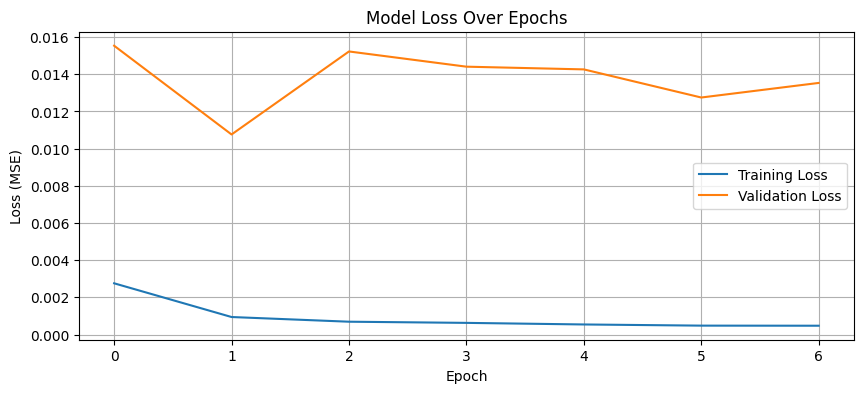

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step
model_23features_2021_30D      | MAE:  3.249  MSE: 29.575  RMSE:  5.438  R²:  0.758


,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_23features_2021_30D,3.248668,29.574916,5.438282,0.758228,2021-12-31,"JKM_Price, PSV_Price, TTF_Price, TTFMc1_Close,..."


In [ ]:
# @title Reproduce the best model with the highest postwar results with the 23 features

# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['JKM_Price', 'PSV_Price', 'TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close', 'TTFMc3_Close',
                                 'Temp_Southern_Hemisphere', 'Temp_Global', 'Temp_Northern_Hemisphere', 'Brent_Price',
                                 'Brent_Volume', 'Coal_Price', 'TTFMc1_Bid', 'TTFMc1_Ask', 'CBOE_Price', 'TTFMc2_Bid',
                                 'HH_Price', 'NBP_Price', 'JKM_Price_pct_change', 'MA_7', 'Volatility_30', 'return_30', 'return_60']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 180
horizon_days = 30
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)


print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Build and Train the LSTM Model

# Build model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),     # First LSTM layer returns sequence
    Dropout(0.4),
    LSTM(32),                            # Second LSTM layer outputs a vector
    Dropout(0.2),
    Dense(1)                             # Predict a single target value
])

model.compile(
    optimizer=Adam(),
    loss='mse',
   metrics=[
        MeanAbsoluteError(name='mae'),
        RootMeanSquaredError(name='rmse'),
        MeanAbsolutePercentageError(name='mape')
    ]
  )
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # Watch this metric
    factor=0.5,             # Reduce LR by half
    patience=3,             # Wait for 3 epochs with no improvement
    verbose=1               # Print updates
)

# Manual chronological split from training set (e.g., last 10% of X_train)
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]


# Train model
history = model.fit(X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
    verbose=1)

plot_loss(history)

#@title Evaluate the model result by inverse y_test and y_pred during  war and post war periods

# After model prediction (in scaled space)
y_pred_scaled = model.predict(X_test)

# Inverse just the price component
y_pred = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])


evaluation_metrics(y_test, y_pred, label = 'model_23features_2021_30D', cutoff_date = cutoff_date, results_df = results_df, features = features.columns.tolist())

In [ ]:
# --- Step 3: Construct datetime index for y_test/y_pred ---
test_start_idx = split_idx + 1 - buffer
forecast_start_idx = test_start_idx + window_size + horizon_days - 1
forecast_dates = df_selected_features.index[forecast_start_idx : forecast_start_idx + len(y_test)]

y_pred_series = pd.Series(y_pred.flatten(), index=forecast_dates)
y_test_series = pd.Series(y_test.flatten(), index=forecast_dates)

# --- Step 4: Define period masks ---
war_mask = (forecast_dates >= '2022-01-01') & (forecast_dates <= '2023-03-31')
postwar_mask = forecast_dates > '2023-03-31'

# --- Step 5: Evaluate both periods ---
results_df = evaluation_metrics(
    y_test_series[war_mask], y_pred_series[war_mask],
    label = 'model_23features_2021_30D_war', cutoff_date = cutoff_date, results_df = results_df, features = features.columns.tolist()
)

results_df = evaluation_metrics(
    y_test_series[postwar_mask], y_pred_series[postwar_mask],
    label = 'model_23features_2021_30D_PostWar', cutoff_date = cutoff_date, results_df = results_df, features = features.columns.tolist())

model_23features_2021_30D_war  | MAE:  6.963  MSE: 79.326  RMSE:  8.907  R²:  0.349
model_23features_2021_30D_PostWar | MAE:  1.222  MSE:  2.432  RMSE:  1.560  R²:  0.448


/tmp/ipython-input-9-2480398775.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df.loc[len(results_df)] = [label, mae, mse, rmse, r2, cutoff_date, features_str]


In [ ]:
results_df

,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_23features_2021_30D,3.248668,29.574916,5.438282,0.758228,2021-12-31,"JKM_Price, PSV_Price, TTF_Price, TTFMc1_Close,..."
1,model_23features_2021_30D_war,6.962743,79.326331,8.906533,0.348901,2021-12-31,"JKM_Price, PSV_Price, TTF_Price, TTFMc1_Close,..."
2,model_23features_2021_30D_PostWar,1.222405,2.432358,1.559602,0.448128,2021-12-31,"JKM_Price, PSV_Price, TTF_Price, TTFMc1_Close,..."


In [ ]:
#results_df = results_df[results_df['Label']=='model_23features_2021_30D']


,Label,MAE,MSE,RMSE,R2,cutoff_date,features
0,model_23features_2021_30D,3.248668,29.574916,5.438282,0.758228,2021-12-31,"JKM_Price, PSV_Price, TTF_Price, TTFMc1_Close,..."


In [ ]:
save_model_and_history(model,
                       history,
                       save_dir='/content/drive/My Drive/BKW/Models/JKM',
                       model_name='JKM_lstm_model_23selected_features_30D')

✅ Model saved to: /content/drive/My Drive/BKW/Models/JKM/JKM_lstm_model_23selected_features_30D.keras
✅ History saved to: /content/drive/My Drive/BKW/Models/JKM/JKM_lstm_model_23selected_features_30D_history.pkl


In [ ]:
features.columns.tolist()

['JKM_Price',
 'PSV_Price',
 'TTF_Price',
 'TTFMc1_Close',
 'TTFMc2_Close',
 'TTFMc3_Close',
 'Temp_Southern_Hemisphere',
 'Temp_Global',
 'Temp_Northern_Hemisphere',
 'Brent_Price',
 'Brent_Volume',
 'Coal_Price',
 'TTFMc1_Bid',
 'TTFMc1_Ask',
 'CBOE_Price',
 'TTFMc2_Bid',
 'HH_Price',
 'NBP_Price',
 'JKM_Price_pct_change',
 'MA_7',
 'Volatility_30',
 'return_30',
 'return_60']

In [ ]:
os.makedirs("/content/drive/My Drive/BKW/Models/JKM/", exist_ok=True)

In [ ]:
features = df_selected_features[['JKM_Price', 'PSV_Price', 'TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close', 'TTFMc3_Close',
                                 'Temp_Southern_Hemisphere', 'Temp_Global', 'Temp_Northern_Hemisphere', 'Brent_Price',
                                 'Brent_Volume', 'Coal_Price', 'TTFMc1_Bid', 'TTFMc1_Ask', 'CBOE_Price', 'TTFMc2_Bid',
                                 'HH_Price', 'NBP_Price', 'JKM_Price_pct_change', 'MA_7', 'Volatility_30', 'return_30', 'return_60']]

In [ ]:
#@title reset the gridsearch and save the best models
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tqdm import tqdm

# Set global seed for reproducibility
def set_global_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

set_global_seed(42)

# Optional: ensure deterministic ops
# tf.config.experimental.enable_op_determinism()

# Feature selection
feature_cols = features.columns.tolist()
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_selected_features[feature_cols])
total_features = scaled.shape[1]

# Hyperparameter grid
window_sizes = [90, 180, 365]
horizon_days_list = [30, 60, 90]
lstm_units_list = [(32, 16), (64, 32)]
dropout_configs = [(0.4, 0.2), (0.5, 0.3)]

cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)

experiment_results = []
best_mae_by_horizon = {}

for window_size in tqdm(window_sizes, desc='Window Sizes'):
    for horizon_days in tqdm(horizon_days_list, desc=f'Horizons for {window_size}', leave=False):
        buffer = window_size + horizon_days - 1
        scaled_train = scaled[:split_idx + 1]
        scaled_test = scaled[split_idx + 1 - buffer:]

        try:
            X_train, y_train = create_sequences_multifeature(scaled_train, window_size, horizon_days)
            X_test, y_test = create_sequences_multifeature(scaled_test, window_size, horizon_days)
        except:
            print(f"❌ Skipping combo: window={window_size}, horizon={horizon_days} — sequence creation failed")
            continue

        if len(X_train) < 10:
            print(f"⚠️ Too few training samples for window={window_size}, horizon={horizon_days}")
            continue

        val_size = int(len(X_train) * 0.1)
        X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
        y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]

        for lstm1, lstm2 in lstm_units_list:
            for drop1, drop2 in dropout_configs:
                set_global_seed(42)  # reset seed before every model
                tf.keras.backend.clear_session()

                model = Sequential([
                    Input(shape=(X_train.shape[1], X_train.shape[2])),
                    LSTM(lstm1, return_sequences=True),
                    Dropout(drop1),
                    LSTM(lstm2),
                    Dropout(drop2),
                    Dense(1)
                ])
                model.compile(
                    optimizer=Adam(),
                    loss='mse',
                    metrics=[MeanAbsoluteError(name='mae'), RootMeanSquaredError(name='rmse'), MeanAbsolutePercentageError(name='mape')]
                )

                early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)

                model.fit(
                    X_train_sub, y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, lr_scheduler],
                    verbose=0
                )

                y_pred_scaled = model.predict(X_test, verbose=0)
                y_pred_inv = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=total_features)
                y_test_inv = inverse_single_feature(scaler, y_test, feature_index=0, total_features=total_features)

                mae = mean_absolute_error(y_test_inv, y_pred_inv)
                mse = mean_squared_error(y_test_inv, y_pred_inv)
                rmse = np.sqrt(mse)
                mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
                r2 = r2_score(y_test_inv, y_pred_inv)

                experiment_results.append({
                    'cutoff_date': cutoff_date,
                    'window_size': window_size,
                    'horizon_days': horizon_days,
                    'lstm1': lstm1,
                    'lstm2': lstm2,
                    'drop1': drop1,
                    'drop2': drop2,
                    'mae': mae,
                    'rmse': rmse,
                    'mape': mape,
                    'R2': r2,
                    'seed': 42
                })

                key = f"horizon_{horizon_days}"
                if key not in best_mae_by_horizon or mae < best_mae_by_horizon[key]:
                    model.save(f"/content/drive/My Drive/BKW/Models/JKM/best_model_h{horizon_days}.keras")
                    best_mae_by_horizon[key] = mae

                if len(experiment_results) % 5 == 0:
                    pd.DataFrame(experiment_results).to_csv("/content/drive/My Drive/BKW/Models/JKM/model_23selected_features_gridsearch_checkpoint.csv", index=False)

# Save final results
results_df = pd.DataFrame(experiment_results)
results_df.to_csv("/content/drive/My Drive/BKW/Models/JKM/model_23selected_features_gridsearch.csv", index=False)

Window Sizes: 100%|██████████| 3/3 [14:36<00:00, 292.12s/it]


In [ ]:
results_df.sort_values('mae')

,cutoff_date,window_size,horizon_days,lstm1,lstm2,drop1,drop2,mae,rmse,mape,R2,seed
14,2021-12-31,180,30,64,32,0.4,0.2,3.247601,5.552762,13.821341,0.747942,42
12,2021-12-31,180,30,32,16,0.4,0.2,3.278172,5.649305,14.316373,0.739101,42
15,2021-12-31,180,30,64,32,0.5,0.3,3.280643,5.634561,13.879752,0.740461,42
13,2021-12-31,180,30,32,16,0.5,0.3,3.338683,5.919704,14.332235,0.713528,42
26,2021-12-31,365,30,64,32,0.4,0.2,3.423688,5.781050,14.664576,0.726791,42
27,2021-12-31,365,30,64,32,0.5,0.3,3.469929,5.800103,14.948875,0.724987,42
1,2021-12-31,90,30,32,16,0.5,0.3,3.717252,5.708230,17.204166,0.733630,42
0,2021-12-31,90,30,32,16,0.4,0.2,3.780508,5.731378,17.750463,0.731466,42
2,2021-12-31,90,30,64,32,0.4,0.2,3.786021,5.895762,17.371018,0.715841,42
3,2021-12-31,90,30,64,32,0.5,0.3,3.999156,6.205675,18.477844,0.685182,42


In [ ]:
best_mae = results_df.loc[
    results_df.groupby(['horizon_days'])['mae'].idxmin()
].reset_index(drop=True)
best_mae

,cutoff_date,window_size,horizon_days,lstm1,lstm2,drop1,drop2,mae,rmse,mape,R2,seed
0,2021-12-31,180,30,64,32,0.4,0.2,3.247601,5.552762,13.821341,0.747942,42
1,2021-12-31,90,60,32,16,0.5,0.3,4.254645,7.127399,19.073048,0.584717,42
2,2021-12-31,365,90,64,32,0.4,0.2,4.775987,7.839254,26.107125,0.497621,42


# Use the best model from the grid search to forecast 30 days horizon

In [ ]:
# load the model
model_loaded, history = load_model_and_history('/content/drive/My Drive/BKW/Models/JKM', model_name='best_model_h30')

✅ Model loaded from: /content/drive/My Drive/BKW/Models/JKM/best_model_h30.keras
⚠️ History file not found at: /content/drive/My Drive/BKW/Models/JKM/best_model_h30_history.pkl


In [ ]:
#@title Reproduce the y_test and y_pred using the model loaded
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['JKM_Price', 'PSV_Price', 'TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close', 'TTFMc3_Close',
                                 'Temp_Southern_Hemisphere', 'Temp_Global', 'Temp_Northern_Hemisphere', 'Brent_Price',
                                 'Brent_Volume', 'Coal_Price', 'TTFMc1_Bid', 'TTFMc1_Ask', 'CBOE_Price', 'TTFMc2_Bid',
                                 'HH_Price', 'NBP_Price', 'JKM_Price_pct_change', 'MA_7', 'Volatility_30', 'return_30', 'return_60']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 180
horizon_days = 30
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)

y_pred_scaled = model_loaded.predict(X_test)
y_pred = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

test_start_idx = split_idx + 1 - buffer
forecast_made_start_idx = test_start_idx + window_size - 1   # Last day of input sequence
forecast_dates = df_selected_features.index[forecast_made_start_idx : forecast_made_start_idx + len(y_test)]

save_lstm_forecast_results_full(
    forecast_dates,
    features,
    y_pred,
    y_test,
    horizon_days,
    save_path='/content/drive/My Drive/BKW/reports/JKM_forecast/JKM_lstm_model_23features_30_forecast.csv')

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
✅ Forecast results saved to: /content/drive/My Drive/BKW/reports/JKM_forecast/JKM_lstm_model_23features_30_forecast.csv


,JKM_Price,PSV_Price,TTF_Price,TTFMc1_Close,TTFMc2_Close,TTFMc3_Close,Temp_Southern_Hemisphere,Temp_Global,Temp_Northern_Hemisphere,Brent_Price,...,TTFMc2_Bid,HH_Price,NBP_Price,JKM_Price_pct_change,MA_7,Volatility_30,return_30,return_60,Predicted_30D,Actual_30D
Date,,,,,,,,,,,,,,,,,,,,,
2012-11-26,14.324000,28.03,27.40,27.40,27.55,27.55,14.648,13.073,11.554,110.92,...,27.52,3.75,66.80,0.005065,14.107455,0.277568,0.061037,0.034224,<NA>,<NA>
2012-11-27,14.396182,28.00,27.65,27.45,27.55,27.62,14.710,13.033,11.411,109.87,...,27.55,3.77,66.85,0.005039,14.179636,0.302843,0.066384,0.013816,<NA>,<NA>
2012-11-28,14.468364,28.05,27.55,27.40,27.60,27.60,14.778,13.051,11.380,109.51,...,27.58,3.71,67.15,0.005014,14.251818,0.328481,0.071731,0.018899,<NA>,<NA>
2012-11-29,14.540545,28.05,27.50,27.33,27.55,27.50,14.909,13.050,11.248,110.76,...,27.52,3.61,67.00,0.004989,14.324000,0.352678,0.081081,0.023982,<NA>,<NA>
2012-11-30,14.612727,28.20,27.60,27.45,27.60,27.75,14.923,12.980,11.095,111.23,...,27.10,3.46,67.30,0.004964,14.396182,0.376613,0.086448,0.029065,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-08,13.160000,43.45,40.03,34.58,34.81,35.08,11.409,16.432,21.496,69.31,...,34.28,3.26,96.70,0.000000,13.160714,0.591563,0.057736,0.147841,<NA>,<NA>
2025-07-09,13.160000,43.45,40.03,34.38,34.90,35.28,11.409,16.432,21.496,69.31,...,34.90,3.26,96.70,0.000000,13.160000,0.568840,0.057878,0.148676,<NA>,<NA>
2025-07-10,13.160000,43.45,40.03,35.20,35.51,35.70,11.409,16.432,21.496,69.31,...,35.65,3.26,96.70,0.000000,13.160000,0.542282,0.060435,0.149512,<NA>,<NA>


In [ ]:
#@title Use the model to predict based on the latest available data

# --- CONFIG ---
csv_path = '/content/drive/My Drive/BKW/reports/JKM_forecast/JKM_lstm_model_23features_30_forecast.csv'
model_path = '/content/drive/My Drive/BKW/Models/JKM/best_model_h30.keras'
window_size = window_size          # e.g., 365 days of lookback
horizon_days = horizon_days          # ⬅️ adapt this to 60 or other values as needed
target_feature_index = 0   # u
prediction_col = f'Predicted_{horizon_days}D'

# --- Load Data ---
df = pd.read_csv(csv_path, parse_dates=['Date'], index_col='Date')

# --- Add prediction column if missing ---
if prediction_col not in df.columns:
    df[prediction_col] = np.nan

# --- Define features ---
feature_cols = features.columns.tolist()

# --- Fit Scaler ---
scaler = MinMaxScaler()
scaler.fit(df[feature_cols])

# --- Load Model ---
model = load_model(model_path)

# --- Define forecast range: last `horizon_days` rows ---
start_idx = len(df) - horizon_days

for i in range(start_idx, len(df)):
    t = df.index[i]

    # skip if not enough history
    if i - window_size + 1 < 0:
        continue

    # get and scale window
    window_data = df.iloc[i - window_size + 1 : i + 1][feature_cols].values
    window_scaled = scaler.transform(window_data)
    X_input = window_scaled.reshape(1, window_size, len(feature_cols))

    # predict and inverse transform
    pred_scaled = model.predict(X_input, verbose=0)
    dummy_input = np.zeros((1, len(feature_cols)))
    dummy_input[0, target_feature_index] = pred_scaled[0][0]
    pred_unscaled = scaler.inverse_transform(dummy_input)[0][target_feature_index]

    # store result
    df.loc[t, prediction_col] = pred_unscaled

# --- (Optional) Save result ---
# df.to_csv(csv_path)

# --- Show result ---
df.tail(horizon_days + 1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

,JKM_Price,PSV_Price,TTF_Price,TTFMc1_Close,TTFMc2_Close,TTFMc3_Close,Temp_Southern_Hemisphere,Temp_Global,Temp_Northern_Hemisphere,Brent_Price,...,TTFMc2_Bid,HH_Price,NBP_Price,JKM_Price_pct_change,MA_7,Volatility_30,return_30,return_60,Predicted_30D,Actual_30D
Date,,,,,,,,,,,,,,,,,,,,,
2025-06-12,12.460000,39.650000,35.900000,36.380000,36.350000,36.780000,12.487,16.528,20.612,69.360000,...,36.150000,2.900000,86.500000,0.001205,12.440714,0.284123,0.087260,-0.005454,11.512405,13.16
2025-06-13,12.504000,41.000000,37.630000,38.190000,38.440000,38.710000,12.489,16.545,20.643,74.230000,...,38.460000,2.650000,91.000000,0.003531,12.449143,0.242884,0.089673,-0.001278,11.303204,NaN
2025-06-14,12.864333,41.266667,37.596667,37.943333,38.340000,38.556667,12.423,16.518,20.655,73.483333,...,38.393333,2.733333,90.533333,0.028817,12.509286,0.210792,0.118832,0.032285,11.086641,NaN
2025-06-15,13.224667,41.533333,37.563333,37.696667,38.240000,38.403333,12.350,16.542,20.775,72.736667,...,38.326667,2.816667,90.066667,0.028010,12.621143,0.246716,0.111784,0.115065,10.957013,NaN
2025-06-16,13.585000,41.800000,37.530000,37.450000,38.140000,38.250000,12.371,16.557,20.785,71.990000,...,38.260000,2.900000,89.600000,0.027247,12.784714,0.312697,0.139841,0.124121,10.944499,NaN
2025-06-17,14.005000,42.000000,39.450000,39.600000,38.900000,39.420000,12.353,16.573,20.834,74.900000,...,39.380000,2.900000,94.250000,0.030916,13.012571,0.407641,0.172784,0.158875,11.021048,NaN
2025-06-18,13.880000,42.300000,39.400000,39.850000,40.070000,39.550000,12.276,16.570,20.905,75.140000,...,39.960000,3.430000,95.500000,-0.008925,13.217571,0.462792,0.160050,0.148531,11.127749,NaN
2025-06-19,14.067500,44.150000,41.500000,40.280000,40.950000,41.350000,12.183,16.536,20.929,77.080000,...,41.350000,3.260000,98.000000,0.013509,13.447214,0.535152,0.124051,0.164046,11.323890,NaN
2025-06-20,14.255000,43.450000,40.030000,40.650000,41.200000,41.750000,12.139,16.532,20.966,75.480000,...,40.250000,3.090000,96.700000,0.013329,13.697357,0.609503,0.142228,0.179561,11.548968,NaN


In [ ]:
df.to_csv('/content/drive/My Drive/BKW/reports/JKM_forecast/30d_prediction_model_23features.csv')

# Use the best model from the grid search to forecast 60 days horizon

In [ ]:
# load the model
model_loaded, history = load_model_and_history('/content/drive/My Drive/BKW/Models/JKM', model_name='best_model_h60')

✅ Model loaded from: /content/drive/My Drive/BKW/Models/JKM/best_model_h60.keras
⚠️ History file not found at: /content/drive/My Drive/BKW/Models/JKM/best_model_h60_history.pkl


In [ ]:
#@title Reproduce the y_test and y_pred using the model loaded
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['JKM_Price', 'PSV_Price', 'TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close', 'TTFMc3_Close',
                                 'Temp_Southern_Hemisphere', 'Temp_Global', 'Temp_Northern_Hemisphere', 'Brent_Price',
                                 'Brent_Volume', 'Coal_Price', 'TTFMc1_Bid', 'TTFMc1_Ask', 'CBOE_Price', 'TTFMc2_Bid',
                                 'HH_Price', 'NBP_Price', 'JKM_Price_pct_change', 'MA_7', 'Volatility_30', 'return_30', 'return_60']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 90
horizon_days = 60
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)

y_pred_scaled = model_loaded.predict(X_test)
y_pred = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

test_start_idx = split_idx + 1 - buffer
forecast_made_start_idx = test_start_idx + window_size - 1   # Last day of input sequence
forecast_dates = df_selected_features.index[forecast_made_start_idx : forecast_made_start_idx + len(y_test)]

save_lstm_forecast_results_full(
    forecast_dates,
    features,
    y_pred,
    y_test,
    horizon_days,
    save_path='/content/drive/My Drive/BKW/reports/JKM_forecast/JKM_lstm_model_2selected_features_90_forecast.csv')

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
✅ Forecast results saved to: /content/drive/My Drive/BKW/reports/JKM_forecast/JKM_lstm_model_2selected_features_90_forecast.csv


,JKM_Price,PSV_Price,TTF_Price,TTFMc1_Close,TTFMc2_Close,TTFMc3_Close,Temp_Southern_Hemisphere,Temp_Global,Temp_Northern_Hemisphere,Brent_Price,...,TTFMc2_Bid,HH_Price,NBP_Price,JKM_Price_pct_change,MA_7,Volatility_30,return_30,return_60,Predicted_60D,Actual_60D
Date,,,,,,,,,,,,,,,,,,,,,
2012-11-26,14.324000,28.03,27.40,27.40,27.55,27.55,14.648,13.073,11.554,110.92,...,27.52,3.75,66.80,0.005065,14.107455,0.277568,0.061037,0.034224,<NA>,<NA>
2012-11-27,14.396182,28.00,27.65,27.45,27.55,27.62,14.710,13.033,11.411,109.87,...,27.55,3.77,66.85,0.005039,14.179636,0.302843,0.066384,0.013816,<NA>,<NA>
2012-11-28,14.468364,28.05,27.55,27.40,27.60,27.60,14.778,13.051,11.380,109.51,...,27.58,3.71,67.15,0.005014,14.251818,0.328481,0.071731,0.018899,<NA>,<NA>
2012-11-29,14.540545,28.05,27.50,27.33,27.55,27.50,14.909,13.050,11.248,110.76,...,27.52,3.61,67.00,0.004989,14.324000,0.352678,0.081081,0.023982,<NA>,<NA>
2012-11-30,14.612727,28.20,27.60,27.45,27.60,27.75,14.923,12.980,11.095,111.23,...,27.10,3.46,67.30,0.004964,14.396182,0.376613,0.086448,0.029065,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-08,13.160000,43.45,40.03,34.58,34.81,35.08,11.409,16.432,21.496,69.31,...,34.28,3.26,96.70,0.000000,13.160714,0.591563,0.057736,0.147841,<NA>,<NA>
2025-07-09,13.160000,43.45,40.03,34.38,34.90,35.28,11.409,16.432,21.496,69.31,...,34.90,3.26,96.70,0.000000,13.160000,0.568840,0.057878,0.148676,<NA>,<NA>
2025-07-10,13.160000,43.45,40.03,35.20,35.51,35.70,11.409,16.432,21.496,69.31,...,35.65,3.26,96.70,0.000000,13.160000,0.542282,0.060435,0.149512,<NA>,<NA>


In [ ]:
#@title Use the model to predict based on the latest available data

# --- CONFIG ---
csv_path = '/content/drive/My Drive/BKW/reports/JKM_forecast/JKM_lstm_model_2selected_features_90_forecast.csv'
model_path = '/content/drive/My Drive/BKW/Models/JKM/best_model_h60.keras'
window_size = window_size          # e.g., 365 days of lookback
horizon_days = horizon_days          # ⬅️ adapt this to 60 or other values as needed
target_feature_index = 0   # u
prediction_col = f'Predicted_{horizon_days}D'

# --- Load Data ---
df = pd.read_csv(csv_path, parse_dates=['Date'], index_col='Date')

# --- Add prediction column if missing ---
if prediction_col not in df.columns:
    df[prediction_col] = np.nan

# --- Define features ---
feature_cols = features.columns.tolist()

# --- Fit Scaler ---
scaler = MinMaxScaler()
scaler.fit(df[feature_cols])

# --- Load Model ---
model = load_model(model_path)

# --- Define forecast range: last `horizon_days` rows ---
start_idx = len(df) - horizon_days

for i in range(start_idx, len(df)):
    t = df.index[i]

    # skip if not enough history
    if i - window_size + 1 < 0:
        continue

    # get and scale window
    window_data = df.iloc[i - window_size + 1 : i + 1][feature_cols].values
    window_scaled = scaler.transform(window_data)
    X_input = window_scaled.reshape(1, window_size, len(feature_cols))

    # predict and inverse transform
    pred_scaled = model.predict(X_input, verbose=0)
    dummy_input = np.zeros((1, len(feature_cols)))
    dummy_input[0, target_feature_index] = pred_scaled[0][0]
    pred_unscaled = scaler.inverse_transform(dummy_input)[0][target_feature_index]

    # store result
    df.loc[t, prediction_col] = pred_unscaled

# --- (Optional) Save result ---
# df.to_csv(csv_path)

# --- Show result ---
df.tail(horizon_days + 1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

,JKM_Price,PSV_Price,TTF_Price,TTFMc1_Close,TTFMc2_Close,TTFMc3_Close,Temp_Southern_Hemisphere,Temp_Global,Temp_Northern_Hemisphere,Brent_Price,...,TTFMc2_Bid,HH_Price,NBP_Price,JKM_Price_pct_change,MA_7,Volatility_30,return_30,return_60,Predicted_60D,Actual_60D
Date,,,,,,,,,,,,,,,,,,,,,
2025-05-13,11.460000,38.97,35.400000,35.70,35.80,36.145,13.567,15.787,18.055,66.630000,...,34.50,3.270000,78.55,0.001748,11.447143,0.389933,-0.085273,-0.160070,9.650843,13.16
2025-05-14,11.475000,37.60,34.450000,34.75,34.90,35.780,13.528,15.781,18.081,66.090000,...,34.00,3.310000,78.65,0.001309,11.456429,0.347690,-0.083466,-0.149328,9.683786,NaN
2025-05-15,11.498000,37.35,34.950000,35.28,34.70,35.600,13.465,15.737,18.056,64.530000,...,34.95,3.200000,81.00,0.002004,11.463286,0.301798,-0.077355,-0.137736,9.681982,NaN
2025-05-16,11.895000,38.48,35.000000,35.14,35.40,36.010,13.391,15.739,18.135,65.410000,...,35.00,3.010000,80.25,0.034528,11.524714,0.303240,0.002951,-0.097496,9.717562,NaN
2025-05-17,11.918333,38.63,35.033333,35.16,35.32,35.820,13.406,15.770,18.182,65.206667,...,35.06,2.993333,81.60,0.001962,11.590667,0.293852,-0.013791,-0.090551,9.756333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-08,13.160000,43.45,40.030000,34.58,34.81,35.080,11.409,16.432,21.496,69.310000,...,34.28,3.260000,96.70,0.000000,13.160714,0.591563,0.057736,0.147841,12.481729,NaN
2025-07-09,13.160000,43.45,40.030000,34.38,34.90,35.280,11.409,16.432,21.496,69.310000,...,34.90,3.260000,96.70,0.000000,13.160000,0.568840,0.057878,0.148676,12.516083,NaN
2025-07-10,13.160000,43.45,40.030000,35.20,35.51,35.700,11.409,16.432,21.496,69.310000,...,35.65,3.260000,96.70,0.000000,13.160000,0.542282,0.060435,0.149512,12.535518,NaN


In [ ]:
df.to_csv('/content/drive/My Drive/BKW/reports/JKM_forecast/60d_prediction_model_23features.csv')

# Use the best model from the grid search to forecast 90 days horizon

In [ ]:
# load the model
model_loaded, history = load_model_and_history('/content/drive/My Drive/BKW/Models/JKM', model_name='best_model_h90')

✅ Model loaded from: /content/drive/My Drive/BKW/Models/JKM/best_model_h90.keras
⚠️ History file not found at: /content/drive/My Drive/BKW/Models/JKM/best_model_h90_history.pkl


In [ ]:
#@title Reproduce the y_test and y_pred using the model loaded
# Step 1: Scale the features
scaler = MinMaxScaler()
features = df_selected_features[['JKM_Price', 'PSV_Price', 'TTF_Price', 'TTFMc1_Close', 'TTFMc2_Close', 'TTFMc3_Close',
                                 'Temp_Southern_Hemisphere', 'Temp_Global', 'Temp_Northern_Hemisphere', 'Brent_Price',
                                 'Brent_Volume', 'Coal_Price', 'TTFMc1_Bid', 'TTFMc1_Ask', 'CBOE_Price', 'TTFMc2_Bid',
                                 'HH_Price', 'NBP_Price', 'JKM_Price_pct_change', 'MA_7', 'Volatility_30', 'return_30', 'return_60']]

scaled = scaler.fit_transform(features)


# Define parameters
window_size = 365
horizon_days = 90
cutoff_date = '2021-12-31'
split_idx = df_selected_features.index.get_loc(cutoff_date)
buffer = window_size + horizon_days - 1


# split the data
scaled_train = scaled[:split_idx + 1]     # up to and including cutoff
scaled_test = scaled[split_idx + 1 - buffer:]  # include buffer to allow test sequence generation

# Now safely create sequences
X_train, y_train = create_sequences_multifeature(scaled_train, window_size=window_size, horizon=horizon_days)
X_test, y_test = create_sequences_multifeature(scaled_test, window_size=window_size, horizon=horizon_days)

y_pred_scaled = model_loaded.predict(X_test)
y_pred = inverse_single_feature(scaler, y_pred_scaled, feature_index=0, total_features=scaled.shape[1])
y_test = inverse_single_feature(scaler, y_test, feature_index=0, total_features=scaled.shape[1])

test_start_idx = split_idx + 1 - buffer
forecast_made_start_idx = test_start_idx + window_size - 1   # Last day of input sequence
forecast_dates = df_selected_features.index[forecast_made_start_idx : forecast_made_start_idx + len(y_test)]

save_lstm_forecast_results_full(
    forecast_dates,
    features,
    y_pred,
    y_test,
    horizon_days,
    save_path='/content/drive/My Drive/BKW/reports/JKM_forecast/JKM_lstm_model_23features_90_forecast.csv')

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
✅ Forecast results saved to: /content/drive/My Drive/BKW/reports/JKM_forecast/JKM_lstm_model_23features_90_forecast.csv


,JKM_Price,PSV_Price,TTF_Price,TTFMc1_Close,TTFMc2_Close,TTFMc3_Close,Temp_Southern_Hemisphere,Temp_Global,Temp_Northern_Hemisphere,Brent_Price,...,TTFMc2_Bid,HH_Price,NBP_Price,JKM_Price_pct_change,MA_7,Volatility_30,return_30,return_60,Predicted_90D,Actual_90D
Date,,,,,,,,,,,,,,,,,,,,,
2012-11-26,14.324000,28.03,27.40,27.40,27.55,27.55,14.648,13.073,11.554,110.92,...,27.52,3.75,66.80,0.005065,14.107455,0.277568,0.061037,0.034224,<NA>,<NA>
2012-11-27,14.396182,28.00,27.65,27.45,27.55,27.62,14.710,13.033,11.411,109.87,...,27.55,3.77,66.85,0.005039,14.179636,0.302843,0.066384,0.013816,<NA>,<NA>
2012-11-28,14.468364,28.05,27.55,27.40,27.60,27.60,14.778,13.051,11.380,109.51,...,27.58,3.71,67.15,0.005014,14.251818,0.328481,0.071731,0.018899,<NA>,<NA>
2012-11-29,14.540545,28.05,27.50,27.33,27.55,27.50,14.909,13.050,11.248,110.76,...,27.52,3.61,67.00,0.004989,14.324000,0.352678,0.081081,0.023982,<NA>,<NA>
2012-11-30,14.612727,28.20,27.60,27.45,27.60,27.75,14.923,12.980,11.095,111.23,...,27.10,3.46,67.30,0.004964,14.396182,0.376613,0.086448,0.029065,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-08,13.160000,43.45,40.03,34.58,34.81,35.08,11.409,16.432,21.496,69.31,...,34.28,3.26,96.70,0.000000,13.160714,0.591563,0.057736,0.147841,<NA>,<NA>
2025-07-09,13.160000,43.45,40.03,34.38,34.90,35.28,11.409,16.432,21.496,69.31,...,34.90,3.26,96.70,0.000000,13.160000,0.568840,0.057878,0.148676,<NA>,<NA>
2025-07-10,13.160000,43.45,40.03,35.20,35.51,35.70,11.409,16.432,21.496,69.31,...,35.65,3.26,96.70,0.000000,13.160000,0.542282,0.060435,0.149512,<NA>,<NA>


In [ ]:
#@title Use the model to predict based on the latest available data

# --- CONFIG ---
csv_path = '/content/drive/My Drive/BKW/reports/JKM_forecast/JKM_lstm_model_23features_90_forecast.csv'
model_path = '/content/drive/My Drive/BKW/Models/JKM/best_model_h90.keras'
window_size = window_size          # e.g., 365 days of lookback
horizon_days = horizon_days          # ⬅️ adapt this to 60 or other values as needed
target_feature_index = 0   # u
prediction_col = f'Predicted_{horizon_days}D'

# --- Load Data ---
df = pd.read_csv(csv_path, parse_dates=['Date'], index_col='Date')

# --- Add prediction column if missing ---
if prediction_col not in df.columns:
    df[prediction_col] = np.nan

# --- Define features ---
feature_cols = features.columns.tolist()

# --- Fit Scaler ---
scaler = MinMaxScaler()
scaler.fit(df[feature_cols])

# --- Load Model ---
model = load_model(model_path)

# --- Define forecast range: last `horizon_days` rows ---
start_idx = len(df) - horizon_days

for i in range(start_idx, len(df)):
    t = df.index[i]

    # skip if not enough history
    if i - window_size + 1 < 0:
        continue

    # get and scale window
    window_data = df.iloc[i - window_size + 1 : i + 1][feature_cols].values
    window_scaled = scaler.transform(window_data)
    X_input = window_scaled.reshape(1, window_size, len(feature_cols))

    # predict and inverse transform
    pred_scaled = model.predict(X_input, verbose=0)
    dummy_input = np.zeros((1, len(feature_cols)))
    dummy_input[0, target_feature_index] = pred_scaled[0][0]
    pred_unscaled = scaler.inverse_transform(dummy_input)[0][target_feature_index]

    # store result
    df.loc[t, prediction_col] = pred_unscaled

# --- (Optional) Save result ---
# df.to_csv(csv_path)

# --- Show result ---
df.tail(horizon_days + 1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

,JKM_Price,PSV_Price,TTF_Price,TTFMc1_Close,TTFMc2_Close,TTFMc3_Close,Temp_Southern_Hemisphere,Temp_Global,Temp_Northern_Hemisphere,Brent_Price,...,TTFMc2_Bid,HH_Price,NBP_Price,JKM_Price_pct_change,MA_7,Volatility_30,return_30,return_60,Predicted_90D,Actual_90D
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-13,12.528333,39.133333,34.033333,34.313333,34.44,34.37,14.831,14.932,15.086,64.84,...,34.306667,3.526667,83.833333,-0.000665,12.635000,0.317793,-0.081770,-0.160299,11.973950,13.16
2025-04-14,12.520000,39.800000,34.300000,34.670000,34.76,34.89,14.801,15.040,15.332,64.88,...,34.760000,3.570000,84.500000,-0.000665,12.598571,0.323679,-0.071859,-0.161701,11.833916,NaN
2025-04-15,12.462000,39.250000,34.250000,34.250000,35.15,34.72,14.726,15.035,15.396,64.67,...,33.470000,3.270000,82.600000,-0.004633,12.554571,0.335737,-0.065443,-0.166421,11.702057,NaN
2025-04-16,11.860000,39.550000,35.630000,35.420000,35.60,35.60,14.640,15.006,15.424,65.85,...,35.460000,3.250000,86.150000,-0.048307,12.436714,0.394791,-0.100152,-0.201347,11.578975,NaN
2025-04-17,12.085000,38.200000,35.250000,35.400000,35.50,35.92,14.566,14.989,15.465,67.96,...,34.440000,2.940000,86.350000,0.018971,12.362429,0.425649,-0.077833,-0.180678,11.475514,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-08,13.160000,43.450000,40.030000,34.580000,34.81,35.08,11.409,16.432,21.496,69.31,...,34.280000,3.260000,96.700000,0.000000,13.160714,0.591563,0.057736,0.147841,13.550932,NaN
2025-07-09,13.160000,43.450000,40.030000,34.380000,34.90,35.28,11.409,16.432,21.496,69.31,...,34.900000,3.260000,96.700000,0.000000,13.160000,0.568840,0.057878,0.148676,13.573337,NaN
2025-07-10,13.160000,43.450000,40.030000,35.200000,35.51,35.70,11.409,16.432,21.496,69.31,...,35.650000,3.260000,96.700000,0.000000,13.160000,0.542282,0.060435,0.149512,13.599544,NaN


In [ ]:
df.to_csv('/content/drive/My Drive/BKW/reports/JKM_forecast/90d_prediction_model_23features.csv')